## Installation needed

In [1]:
# !pip install tensorflow
# !pip install opencv-python
# !pip install keras

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('dark_background')
import seaborn as sns
from tqdm import tqdm

import cv2
import os
import tensorflow as tf
import sklearn as sk

import warnings
warnings.filterwarnings('ignore')

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.4.1


## Import files

In [2]:
main_data = pd.read_csv('data_labels_mainData.csv')
extra_data = pd.read_csv('data_labels_extraData.csv')

In [3]:
main_data

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1


In [4]:
extra_data

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0
...,...,...,...,...
10379,20028,99,20028.png,0
10380,20029,99,20029.png,0
10381,20030,99,20030.png,0
10382,20031,99,20031.png,0


## Image inspect

In [5]:
# Prepare some image of each class
cell0 = main_data['ImageName'].loc[main_data['cellType'] == 0][:4].tolist()
cell1 = main_data['ImageName'].loc[main_data['cellType'] == 1][:4].tolist()
cell2 = main_data['ImageName'].loc[main_data['cellType'] == 2][:4].tolist()
cell3 = main_data['ImageName'].loc[main_data['cellType'] == 3][:4].tolist()

print(cell0)
print(cell1)
print(cell2)
print(cell3)

['22405.png', '22406.png', '22407.png', '22408.png']
['22417.png', '22418.png', '22419.png', '22420.png']
['276.png', '277.png', '278.png', '279.png']
['22423.png', '22424.png', '19061.png', '19062.png']


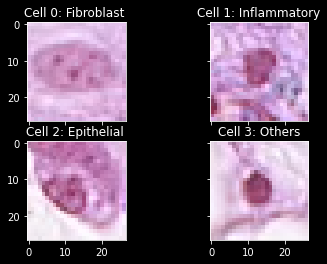

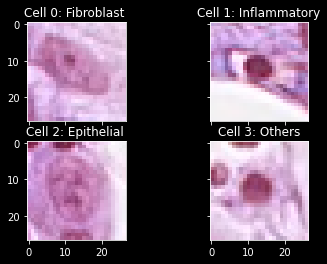

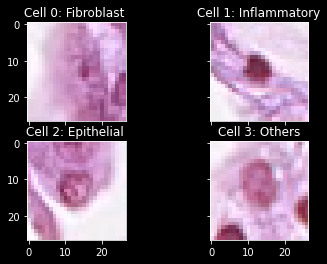

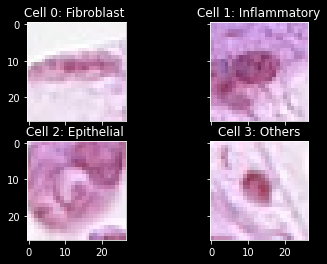

In [6]:
# CHANGE THE DIRECTORY IN YOUR LOCAL MACHINE
# Minh: C:\Users\luong\Documents\GitHub\ML\Asm\ASM2\patch_images
directory = r"C:\Users\User\Desktop\RMIT\Cloud - GitHub\Minh\ML\Asm\ASM2\patch_images"

for i in range (4):
    cell_0 = cv2.imread(os.path.join(directory, cell0[i]))
    cell_1 = cv2.imread(os.path.join(directory, cell1[i]))
    cell_2 = cv2.imread(os.path.join(directory, cell2[i]))
    cell_3 = cv2.imread(os.path.join(directory, cell3[i]))

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    
    ax1.title.set_text("Cell 0: Fibroblast ")
    ax1.imshow(cell_0)
    
    ax2.title.set_text("Cell 1: Inflammatory")
    ax2.imshow(cell_1)
    
    ax3.title.set_text("Cell 2: Epithelial ")
    ax3.imshow(cell_2)
    
    ax4.title.set_text("Cell 3: Others")
    ax4.imshow(cell_3)

    for ax in fig.get_axes():
        ax.label_outer()

## Prepare data

In [7]:
from sklearn.model_selection import train_test_split
X = main_data['ImageName']
y = main_data['cellType']

train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.33)
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.2)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_X.shape[0], val_X.shape[0], test_X.shape[0]))

Train data : 5304, Val Data: 1326, Test Data: 3266


In [8]:
train_Y = train_Y.ravel()
val_Y = val_Y.ravel()
test_Y = test_Y.ravel()

## Transfer to image array

In [9]:
def create_train_data(directory, img_list):
    IMAGE_SIZE = 27
    train_data = []
    for img in tqdm(img_list, desc='Extracting Image Progress'):
        path = os.path.join(directory, img)
        img = cv2.resize(cv2.imread(path), (IMAGE_SIZE,IMAGE_SIZE))
        train_data.append(np.array(img))
    print("Successfully import images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(train_data).astype('float32') / 255.0 

In [10]:
# CHANGE THE PATH TO IMAGE FOLDER IN YOUR LOCAL DEVICE!
# Minh: C:\Users\luong\Documents\GitHub\ML\Asm\ASM2\patch_images
path = r"C:\Users\User\Desktop\RMIT\Cloud - GitHub\Minh\ML\Asm\ASM2\patch_images"

train_X_img = create_train_data(path, train_X.tolist())
val_X_img = create_train_data(path, val_X.tolist())
test_X_img = create_train_data(path, test_X.tolist())

Extracting Image Progress:  25%|██▌       | 332/1326 [00:00<00:00, 3319.62it/s]

Successfully import images!


Extracting Image Progress:  22%|██▏       | 723/3266 [00:00<00:00, 3585.34it/s]

Successfully import images!


Extracting Image Progress: 100%|██████████| 3266/3266 [00:00<00:00, 3455.28it/s]

Successfully import images!


In [11]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(featurewise_center=True,
                                   featurewise_std_normalization=True, 
                                   rotation_range=20, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest', 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2)

In [12]:
train_it = train_datagen.flow(train_X_img, train_Y)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D , Flatten, BatchNormalization, Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27,27, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 64)        2

In [14]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=0.000001)
model.compile(optimizer = opt , 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 64)        2

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("RCC", 
                             monitor='val_acc',
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', period=1)

early = EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

hist = model.fit(train_it, 
                 validation_data = (test_X_img, test_Y), 
                 batch_size = 32, 
                 epochs = 200, 
                 verbose=1,
                 callbacks=[early,checkpoint])

Epoch 1/200
166/166 [==============================] - 11s 58ms/step - loss: 2.0647 - accuracy: 0.2607 - val_loss: 2.1344 - val_accuracy: 0.1412
Epoch 2/200
166/166 [==============================] - 9s 53ms/step - loss: 1.8958 - accuracy: 0.3107 - val_loss: 1.6023 - val_accuracy: 0.2407
Epoch 3/200
166/166 [==============================] - 9s 53ms/step - loss: 1.7578 - accuracy: 0.3428 - val_loss: 1.3687 - val_accuracy: 0.3965
Epoch 4/200
166/166 [==============================] - 9s 53ms/step - loss: 1.6442 - accuracy: 0.3731 - val_loss: 1.3789 - val_accuracy: 0.4284
Epoch 5/200
166/166 [==============================] - 9s 52ms/step - loss: 1.5822 - accuracy: 0.4001 - val_loss: 1.3850 - val_accuracy: 0.4461
Epoch 6/200
166/166 [==============================] - 9s 53ms/step - loss: 1.5568 - accuracy: 0.4186 - val_loss: 1.3651 - val_accuracy: 0.4577
Epoch 7/200
166/166 [==============================] - 9s 53ms/step - loss: 1.4449 - accuracy: 0.4632 - val_loss: 1.3408 - val_accuracy

166/166 [==============================] - 8s 50ms/step - loss: 1.0973 - accuracy: 0.6030 - val_loss: 1.0920 - val_accuracy: 0.5940
Epoch 38/200
166/166 [==============================] - 8s 50ms/step - loss: 1.1390 - accuracy: 0.5862 - val_loss: 1.0883 - val_accuracy: 0.5968
Epoch 39/200
166/166 [==============================] - 8s 49ms/step - loss: 1.1331 - accuracy: 0.5849 - val_loss: 1.0752 - val_accuracy: 0.6010
Epoch 40/200
166/166 [==============================] - 8s 50ms/step - loss: 1.1654 - accuracy: 0.5784 - val_loss: 1.0793 - val_accuracy: 0.6013
Epoch 41/200
166/166 [==============================] - 8s 51ms/step - loss: 1.1154 - accuracy: 0.5928 - val_loss: 1.0839 - val_accuracy: 0.5983
Epoch 42/200
166/166 [==============================] - 8s 51ms/step - loss: 1.1697 - accuracy: 0.5790 - val_loss: 1.0836 - val_accuracy: 0.6001
Epoch 43/200
166/166 [==============================] - 9s 52ms/step - loss: 1.0780 - accuracy: 0.6059 - val_loss: 1.0605 - val_accuracy: 0.608

Epoch 74/200
166/166 [==============================] - 8s 51ms/step - loss: 1.0402 - accuracy: 0.6292 - val_loss: 0.9527 - val_accuracy: 0.6436
Epoch 75/200
166/166 [==============================] - 9s 51ms/step - loss: 1.0751 - accuracy: 0.6114 - val_loss: 0.9541 - val_accuracy: 0.6427
Epoch 76/200
166/166 [==============================] - 8s 51ms/step - loss: 1.0633 - accuracy: 0.6169 - val_loss: 0.9538 - val_accuracy: 0.6433
Epoch 77/200
166/166 [==============================] - 9s 51ms/step - loss: 1.0383 - accuracy: 0.6234 - val_loss: 0.9441 - val_accuracy: 0.6488
Epoch 78/200
166/166 [==============================] - 8s 51ms/step - loss: 1.0705 - accuracy: 0.6153 - val_loss: 0.9436 - val_accuracy: 0.6473
Epoch 79/200
166/166 [==============================] - 8s 51ms/step - loss: 1.0525 - accuracy: 0.6336 - val_loss: 0.9458 - val_accuracy: 0.6513
Epoch 80/200
166/166 [==============================] - 9s 53ms/step - loss: 1.0493 - accuracy: 0.6294 - val_loss: 0.9380 - val_ac

Epoch 111/200
166/166 [==============================] - 9s 52ms/step - loss: 0.9888 - accuracy: 0.6404 - val_loss: 0.8774 - val_accuracy: 0.6699
Epoch 112/200
166/166 [==============================] - 9s 54ms/step - loss: 0.9610 - accuracy: 0.6516 - val_loss: 0.8760 - val_accuracy: 0.6672
Epoch 113/200
166/166 [==============================] - 9s 52ms/step - loss: 0.9758 - accuracy: 0.6315 - val_loss: 0.8702 - val_accuracy: 0.6751
Epoch 114/200
166/166 [==============================] - 8s 51ms/step - loss: 0.9949 - accuracy: 0.6401 - val_loss: 0.8694 - val_accuracy: 0.6739
Epoch 115/200
166/166 [==============================] - 9s 53ms/step - loss: 0.9723 - accuracy: 0.6459 - val_loss: 0.8656 - val_accuracy: 0.6742
Epoch 116/200
166/166 [==============================] - 9s 54ms/step - loss: 1.0117 - accuracy: 0.6298 - val_loss: 0.8691 - val_accuracy: 0.6748
Epoch 117/200
166/166 [==============================] - 9s 54ms/step - loss: 0.9491 - accuracy: 0.6476 - val_loss: 0.8666 -

In [17]:
model.save('Baseline RCCNet')

INFO:tensorflow:Assets written to: Baseline RCCNet\assets


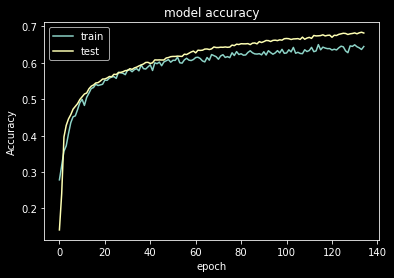

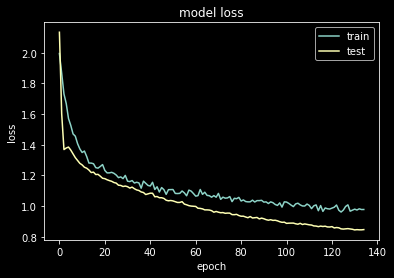

In [18]:
# Summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [19]:
from sklearn.metrics import classification_report
pred = model.predict_classes(test_X_img)
pred.reshape(1,-1)[0]
print(classification_report(test_Y, pred))

              precision    recall  f1-score   support

           0       0.65      0.51      0.57       611
           1       0.58      0.69      0.63       824
           2       0.87      0.82      0.84      1371
           3       0.44      0.47      0.46       460

    accuracy                           0.68      3266
   macro avg       0.63      0.62      0.62      3266
weighted avg       0.69      0.68      0.68      3266

